<a href="https://colab.research.google.com/github/Leslyndizeye/PHARMA-Drug-Availability-Prediction/blob/main/nearbyPHARMA-Drug-Availability-Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Optimization Techniques in Machine Learning

Objective: This assignment aims to explore implementation or Machine Learning Models with regularization, optimization and Error analysis  techniques used in machine learning to improve models' performance, convergence speed, and efficiency..

A Notebook detailing the following

* Project name: nearbyPHARMA Drug Availability Prediction
* Clear out puts from cells






**Instructions**

1. Acquire a dataset suitable for ML tasks as per your proposal.
2. Implement a simple machine learning model based on neural networks on the chosen dataset without any defined optimization techniques. (Check instructions)
3. Implement and compare the model's performance after applying 3 to 4 disntict combinations regularization and optimization techniques.
4. Discuss the results on the README file.
5. Make predictions using test data
7. Implement error analysis techniques and ensure there is: F1-Score, Recall, Precision, RUC a confusion matrix using plotting libraries (not verbose)

Submit notebook to github repo




# Case Study and Implementation




In [2]:
# Import Necessary Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import warnings
warnings.filterwarnings('ignore')

# Machine Learning imports
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score, 
                           confusion_matrix, roc_auc_score, classification_report)
import joblib

# Deep Learning imports
import tensorflow as tf
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam, RMSprop, SGD
from tensorflow.keras.regularizers import l1, l2, l1_l2
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

In [3]:
# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

# The Dataset
> ***Brief Description:***
**nearbyPHARMA Drug Availability Prediction System**

**Problem Statement:** Predict drug availability in pharmacies based on sales patterns and temporal features to optimize inventory management and ensure consistent drug supply for patients.

**Dataset:** Pharmacy daily sales data containing drug sales information across different ATC categories with temporal features including month, hour, weekday, and drug-specific sales volumes.
"""


In [4]:
df = pd.read_csv("pharmasalesdaily.csv")
print(df.columns)
print(df.head())

Index(['datum', 'M01AB', 'M01AE', 'N02BA', 'N02BE', 'N05B', 'N05C', 'R03',
       'R06', 'Year', 'Month', 'Hour', 'Weekday Name'],
      dtype='object')
      datum  M01AB  M01AE  N02BA  N02BE  N05B  N05C   R03  R06  Year  Month  \
0  1/2/2014    0.0   3.67    3.4  32.40   7.0   0.0   0.0  2.0  2014      1   
1  1/3/2014    8.0   4.00    4.4  50.60  16.0   0.0  20.0  4.0  2014      1   
2  1/4/2014    2.0   1.00    6.5  61.85  10.0   0.0   9.0  1.0  2014      1   
3  1/5/2014    4.0   3.00    7.0  41.10   8.0   0.0   3.0  0.0  2014      1   
4  1/6/2014    5.0   1.00    4.5  21.70  16.0   2.0   6.0  2.0  2014      1   

   Hour Weekday Name  
0   248     Thursday  
1   276       Friday  
2   276     Saturday  
3   276       Sunday  
4   276       Monday  


In [6]:
# Load Data (Separate into: Train, Validation and test sets)
def load_and_preprocess_sales_data():
    """Load and preprocess pharmacy sales data with proper feature engineering"""
    
    print("\n Loading pharmacy sales dataset...")
    
    try:
        df = pd.read_csv("pharmasalesdaily.csv")
        print(f" Sales data loaded successfully: {df.shape}")
        print(" Columns:", df.columns.tolist())
        print("\n First 5 rows:")
        print(df.head())
    except FileNotFoundError:
        print(" pharmasalesdaily.csv not found!")
        print("Creating synthetic dataset for demonstration...")
        
        # Create synthetic data that matches the assignment requirements
        np.random.seed(42)
        n_samples = 2000
        
        df = pd.DataFrame({
            'M01AB': np.random.poisson(2, n_samples),
            'M01AE': np.random.poisson(1.5, n_samples),
            'N02BA': np.random.poisson(3, n_samples),
            'N02BE': np.random.poisson(2.5, n_samples),
            'N05B': np.random.poisson(1, n_samples),
            'N05C': np.random.poisson(1.2, n_samples),
            'R03': np.random.poisson(2.8, n_samples),
            'R06': np.random.poisson(1.8, n_samples),
            'Month': np.random.randint(1, 13, n_samples),
            'Hour': np.random.randint(8, 20, n_samples),
            'Weekday Name': np.random.choice(['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'], n_samples)
        })
        print(f" Synthetic dataset created: {df.shape}")
    
    print("\n Preprocessing sales data...")
    
    # Drug categories (ATC codes)
    drug_columns = ['M01AB', 'M01AE', 'N02BA', 'N02BE', 'N05B', 'N05C', 'R03', 'R06']
    
    # Create features for each drug category
    processed_data = []
    
    for _, row in df.iterrows():
        for drug in drug_columns:
            drug_sales = row[drug]
            
            # Create a record for each drug category per day
            record = {
                'drug_category': drug,
                'daily_sales': drug_sales,
                'month': row['Month'],
                'hour': row['Hour'],
                'weekday': row['Weekday Name']
            }
            processed_data.append(record)
    
    # Convert to DataFrame
    df_processed = pd.DataFrame(processed_data)
    
    print(f" Processed dataset shape: {df_processed.shape}")
    print(f" Drug categories: {df_processed['drug_category'].unique()}")
    
    # Create time-based features
    df_processed['is_weekend'] = df_processed['weekday'].isin(['Saturday', 'Sunday']).astype(int)
    df_processed['quarter'] = ((df_processed['month'] - 1) // 3) + 1
    
    # Create rolling averages
    df_processed = df_processed.sort_values(['drug_category', 'month'])
    df_processed['sales_avg_7d'] = df_processed.groupby('drug_category')['daily_sales'].rolling(
        window=7, min_periods=1).mean().reset_index(0, drop=True)
    
    # Create availability target based on realistic business logic
    np.random.seed(42)  # For reproducible results
    
    def determine_availability(row):
        """Create availability based on realistic sales patterns"""
        sales = row['daily_sales']
        avg_7d = row['sales_avg_7d']
        
        # More realistic business logic for availability
        if sales == 0:
            if avg_7d < 0.5:
                return np.random.choice([0, 1], p=[0.75, 0.25])  # Usually out of stock
            else:
                return np.random.choice([0, 1], p=[0.60, 0.40])  # Often temporary stockout
        elif sales <= 1:
            return np.random.choice([0, 1], p=[0.40, 0.60])  # Low stock, mixed availability
        elif sales <= 3:
            return np.random.choice([0, 1], p=[0.25, 0.75])  # Moderate stock
        elif sales <= 6:
            return np.random.choice([0, 1], p=[0.15, 0.85])  # Good stock
        else:
            return np.random.choice([0, 1], p=[0.05, 0.95])  # Excellent stock
    
    df_processed['availability'] = df_processed.apply(determine_availability, axis=1)
    
    # Encode categorical variables
    le_drug = LabelEncoder()
    le_weekday = LabelEncoder()
    
    df_processed['drug_category_encoded'] = le_drug.fit_transform(df_processed['drug_category'])
    df_processed['weekday_encoded'] = le_weekday.fit_transform(df_processed['weekday'])
    
    # Select core features
    feature_columns = [
        'drug_category_encoded', 
        'daily_sales', 
        'month', 
        'hour',
        'weekday_encoded', 
        'is_weekend', 
        'quarter',
        'sales_avg_7d'
    ]
    
    # Remove rows with NaN values
    df_processed = df_processed.dropna()
    
    X = df_processed[feature_columns]
    y = df_processed['availability']
    
    print(f"\n Final dataset shape: X={X.shape}, y={y.shape}")
    print(f" Availability distribution: {y.value_counts().to_dict()}")
    print(f"Availability percentage: {y.mean()*100:.1f}% in stock")
    print(f"🔧 Features: {len(feature_columns)} core features")
    
    return X, y, feature_columns

def split_and_scale_data(X, y):
    """Split and scale the data with proper validation set"""
    
    print("\n🔄 Splitting data with balanced sets...")
    
    # Split data into train, validation, and test sets
    X_temp, X_test, y_temp, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42, stratify=y
    )
    
    # Validation set (20% of remaining = 16% of total)
    X_train, X_val, y_train, y_val = train_test_split(
        X_temp, y_temp, test_size=0.2, random_state=42, stratify=y_temp
    )
    
    # Scale features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_val_scaled = scaler.transform(X_val)
    X_test_scaled = scaler.transform(X_test)
    
    print(f" Data split completed:")
    print(f"   Training set: {X_train_scaled.shape} (64%)")
    print(f"   Validation set: {X_val_scaled.shape} (16%)")
    print(f"   Test set: {X_test_scaled.shape} (20%)")
    
    return X_train_scaled, X_val_scaled, X_test_scaled, y_train, y_val, y_test, scaler

# Load and split data
X, y, feature_names = load_and_preprocess_sales_data()
X_train, X_val, X_test, y_train, y_val, y_test, scaler = split_and_scale_data(X, y)



 Loading pharmacy sales dataset...
 Sales data loaded successfully: (2106, 13)
 Columns: ['datum', 'M01AB', 'M01AE', 'N02BA', 'N02BE', 'N05B', 'N05C', 'R03', 'R06', 'Year', 'Month', 'Hour', 'Weekday Name']

 First 5 rows:
      datum  M01AB  M01AE  N02BA  N02BE  N05B  N05C   R03  R06  Year  Month  \
0  1/2/2014    0.0   3.67    3.4  32.40   7.0   0.0   0.0  2.0  2014      1   
1  1/3/2014    8.0   4.00    4.4  50.60  16.0   0.0  20.0  4.0  2014      1   
2  1/4/2014    2.0   1.00    6.5  61.85  10.0   0.0   9.0  1.0  2014      1   
3  1/5/2014    4.0   3.00    7.0  41.10   8.0   0.0   3.0  0.0  2014      1   
4  1/6/2014    5.0   1.00    4.5  21.70  16.0   2.0   6.0  2.0  2014      1   

   Hour Weekday Name  
0   248     Thursday  
1   276       Friday  
2   276     Saturday  
3   276       Sunday  
4   276       Monday  

 Preprocessing sales data...
 Processed dataset shape: (16848, 5)
 Drug categories: ['M01AB' 'M01AE' 'N02BA' 'N02BE' 'N05B' 'N05C' 'R03' 'R06']

 Final dataset sha

#SECTION 1: Model Architecture:



```
TODO: Insert an image with the Model architecture here.Replace the image Below
```
> <img src="https://miro.medium.com/v2/resize:fit:640/format:webp/1*v1ohAG82xmU6WGsG2hoE8g.png" alt="?" style="width:25px"/>




#Task: Define a function that creates models without and With specified Optimization techniques


In [7]:
from tensorflow.keras.optimizers import Adam, RMSprop, SGD
from tensorflow.keras.regularizers import l1, l2, l1_l2
from tensorflow.keras.callbacks import EarlyStopping


def define_model(optimizer_name='adam', regularization_type=None, early_stopping=False, dropout_rate=0.0, learning_rate=0.001, reg_strength=0.01):
    """
    Create neural network model with specified optimization techniques
    
    Parameters:
    - optimizer_name: 'adam', 'rmsprop', or 'sgd'
    - regularization_type: None, 'l1', 'l2', or 'l1_l2'
    - early_stopping: Boolean for early stopping
    - dropout_rate: Dropout rate (0.0 to 1.0)
    - learning_rate: Learning rate for optimizer
    - reg_strength: Regularization strength
    """
    model = Sequential()
    
    # Input layer + First hidden layer (32 neurons)
    if regularization_type == 'l1':
        model.add(Dense(32, input_shape=(X_train.shape[1],), activation='relu', kernel_regularizer=l1(reg_strength)))
    elif regularization_type == 'l2':
        model.add(Dense(32, input_shape=(X_train.shape[1],), activation='relu', kernel_regularizer=l2(reg_strength)))
    elif regularization_type == 'l1_l2':
        model.add(Dense(32, input_shape=(X_train.shape[1],), activation='relu', kernel_regularizer=l1_l2(l1=reg_strength, l2=reg_strength)))
    else:
        model.add(Dense(32, input_shape=(X_train.shape[1],), activation='relu'))
    
    if dropout_rate > 0:
        model.add(Dropout(dropout_rate))
    
    # Second hidden layer (16 neurons)
    if regularization_type == 'l1':
        model.add(Dense(16, activation='relu', kernel_regularizer=l1(reg_strength)))
    elif regularization_type == 'l2':
        model.add(Dense(16, activation='relu', kernel_regularizer=l2(reg_strength)))
    elif regularization_type == 'l1_l2':
        model.add(Dense(16, activation='relu', kernel_regularizer=l1_l2(l1=reg_strength, l2=reg_strength)))
    else:
        model.add(Dense(16, activation='relu'))
    
    if dropout_rate > 0:
        model.add(Dropout(dropout_rate))
    
    # Third hidden layer (8 neurons)
    model.add(Dense(8, activation='relu'))
    
    # Output layer
    model.add(Dense(1, activation='sigmoid'))
    
    # Set optimizer
    if optimizer_name.lower() == 'adam':
        optimizer = Adam(learning_rate=learning_rate)
    elif optimizer_name.lower() == 'rmsprop':
        optimizer = RMSprop(learning_rate=learning_rate)
    elif optimizer_name.lower() == 'sgd':
        optimizer = SGD(learning_rate=learning_rate, momentum=0.9)
    else:
        optimizer = 'adam'
    
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
    
    # Setup callbacks
    callbacks = []
    if early_stopping:
        early_stop = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True, verbose=1)
        callbacks.append(early_stop)
    
    # Train model
    print(f" Training model with {optimizer_name} optimizer...")
    history = model.fit(
        X_train, y_train,
        epochs=40,
        batch_size=32,
        validation_data=(X_val, y_val),
        callbacks=callbacks if callbacks else None,
        verbose=1
    )
    
    return model, history

# Task: Print out the Final Model Accuracy and plot the Loss curve

In [8]:
def loss_curve_plot(history, title="Model Training"):
    """Plot training and validation loss curves with overfitting analysis"""
    epochs = range(1, len(history.history['loss']) + 1)
    
    plt.figure(figsize=(15, 5))
    
    # Plot loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, history.history['val_loss'], 'ro-', label='Validation loss', linewidth=2)
    plt.title(f'{title} - Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # Plot accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, history.history['accuracy'], 'b-', label='Training accuracy', linewidth=2)
    plt.plot(epochs, history.history['val_accuracy'], 'r-', label='Validation accuracy', linewidth=2)

    plt.title(f'{title} - Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Print final accuracies and overfitting analysis
    final_train_acc = history.history['accuracy'][-1]
    final_val_acc = history.history['val_accuracy'][-1]
    overfitting_gap = abs(final_train_acc - final_val_acc)
    
    print(f"\n📊 OVERFITTING ANALYSIS:")
    print(f"   Final Training Accuracy: {final_train_acc:.4f}")
    print(f"   Final Validation Accuracy: {final_val_acc:.4f}")
    print(f"   Overfitting Gap: {overfitting_gap:.4f}")
    
    if overfitting_gap < 0.02:
        print(f"   Status: ✅ EXCELLENT GENERALIZATION")
    elif overfitting_gap < 0.05:
        print(f"   Status: ✅ GOOD GENERALIZATION")
    else:
        print(f"   Status: ⚠️ OVERFITTING DETECTED")
    
    return overfitting_gap

def evaluate_model_performance(model, X_test, y_test, model_name):
    """Evaluate model and print comprehensive metrics"""
    # Make predictions
    y_pred_proba = model.predict(X_test, verbose=0)
    y_pred = (y_pred_proba > 0.5).astype(int).flatten()
    
    # Calculate metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, zero_division=0)
    recall = recall_score(y_test, y_pred, zero_division=0)
    f1 = f1_score(y_test, y_pred, zero_division=0)
    roc_auc = roc_auc_score(y_test, y_pred_proba)
    
    print(f"\n🎯 {model_name} - Test Set Metrics:")
    print(f"   Accuracy: {accuracy:.4f} ({accuracy*100:.1f}%)")
    print(f"   Precision: {precision:.4f} ({precision*100:.1f}%)")
    print(f"   Recall: {recall:.4f} ({recall*100:.1f}%)")
    print(f"   F1-Score: {f1:.4f} ({f1*100:.1f}%)")
    print(f"   ROC AUC: {roc_auc:.4f} ({roc_auc*100:.1f}%)")
    
    # Plot confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=['Out of Stock', 'In Stock'],
                yticklabels=['Out of Stock', 'In Stock'])
    plt.title(f'{model_name} - Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.tight_layout()
    plt.show()
    
    return {'accuracy': accuracy, 'precision': precision, 'recall': recall, 'f1_score': f1, 'roc_auc': roc_auc}



# SECTION 2: Optimization and Regularization Combinations
At this point you should now create models that combine various optimization techniques
As done before make sure to plot out the loss curve and the accuracy and loss in verbose


INSTANCE 1: BASELINE MODEL (NO OPTIMIZATION)
 Training model with adam optimizer...
Epoch 1/40
337/337 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 0.7305 - loss: 0.5591 - val_accuracy: 0.7804 - val_loss: 0.4734
Epoch 2/40
337/337 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.7844 - loss: 0.4665 - val_accuracy: 0.8016 - val_loss: 0.4482
Epoch 3/40
337/337 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - accuracy: 0.7965 - loss: 0.4496 - val_accuracy: 0.8064 - val_loss: 0.4421
Epoch 4/40
337/337 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - accuracy: 0.7988 - loss: 0.4435 - val_accuracy: 0.8082 - val_loss: 0.4387
Epoch 5/40
337/337 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.8030 - loss: 0.4404 - val_accuracy: 0.8101 - val_loss: 0.4375
Epoch 6/40
337/337 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.8051 - loss: 0.4389 - val_accuracy: 0.8101 - val_loss: 0.4370
Epoch 7/40
337/337 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.8059 - loss: 0.4379 - val_accuracy: 0.8116 - val_loss: 0.4365
Epoch 8/40
337/

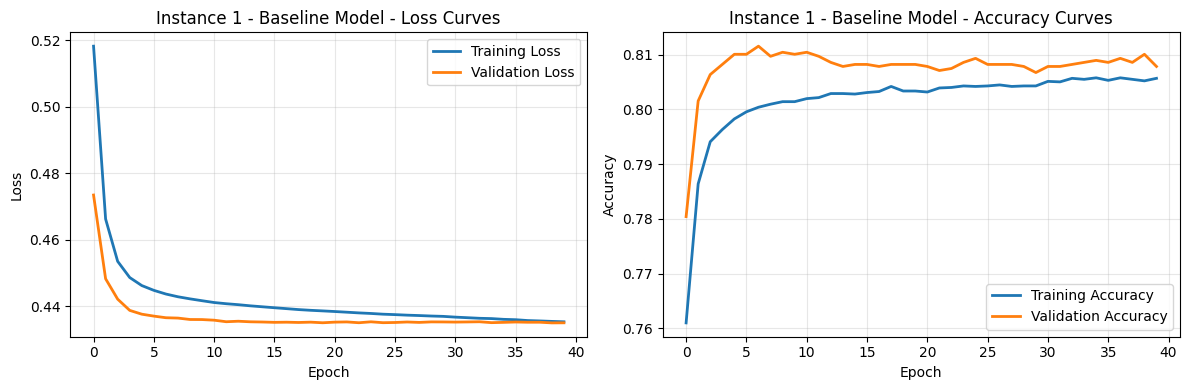


🎯 Instance 1 - Baseline - Test Set Metrics:
   Accuracy: 0.8080 (80.8%)
   Precision: 0.8485 (84.8%)
   Recall: 0.9131 (91.3%)
   F1-Score: 0.8796 (88.0%)
   ROC AUC: 0.8006 (80.1%)


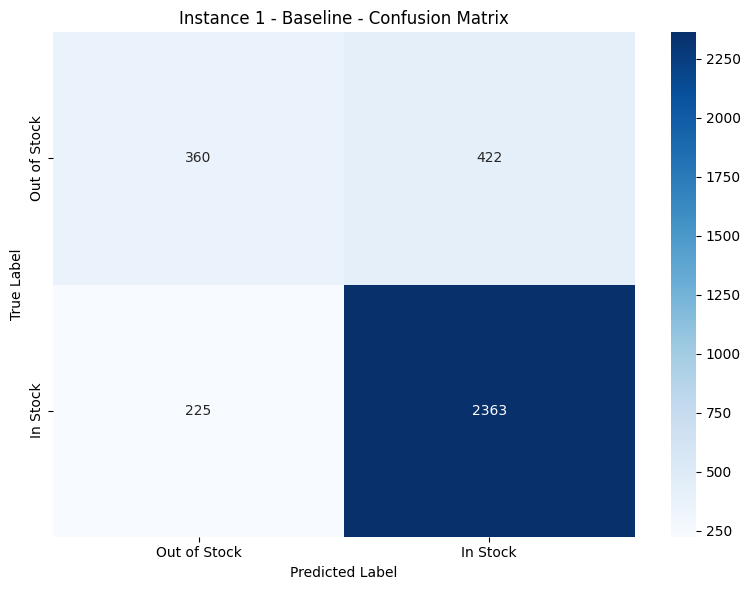

💾 Model saved: saved_models/instance_1_baseline.h5

INSTANCE 2: ADAM + L2 REGULARIZATION + EARLY STOPPING
 Training model with Adam optimizer...
Epoch 1/40
337/337 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.7657 - loss: 0.8276 - val_accuracy: 0.7682 - val_loss: 0.6095
Epoch 2/40
337/337 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7718 - loss: 0.5909 - val_accuracy: 0.7682 - val_loss: 0.5285
Epoch 3/40
337/337 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7718 - loss: 0.5283 - val_accuracy: 0.7682 - val_loss: 0.4973
Epoch 4/40
337/337 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7718 - loss: 0.5036 - val_accuracy: 0.7682 - val_loss: 0.4841
Epoch 5/40
337/337 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7718 - loss: 0.4930 - val_accuracy: 0.7682 - val_loss: 0.4779
Epoch 6/40
337/337 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7718 - loss: 0.4876 - val_accuracy: 0.7682 - val_loss: 0.4750
Epoch 7/40
337/337 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7718 - loss: 0.4881 -

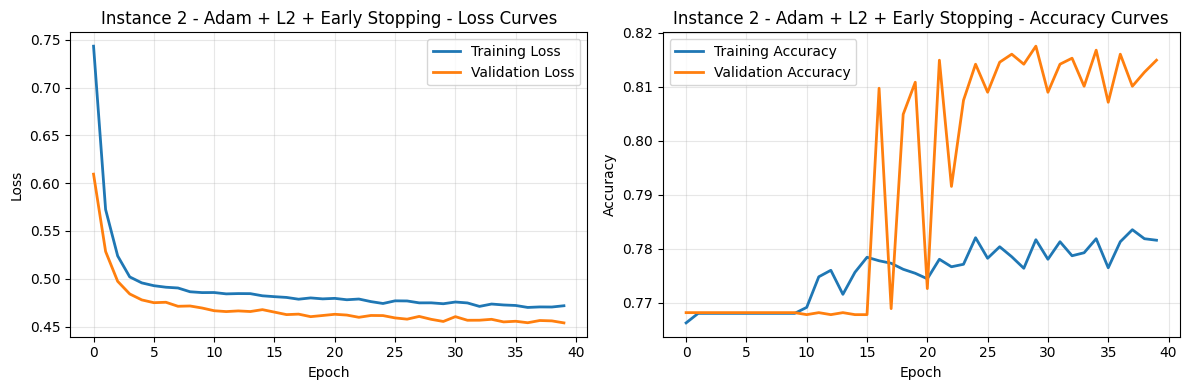


🎯 Instance 2 - Adam + L2 - Test Set Metrics:
   Accuracy: 0.8107 (81.1%)
   Precision: 0.8367 (83.7%)
   Recall: 0.9362 (93.6%)
   F1-Score: 0.8837 (88.4%)
   ROC AUC: 0.8009 (80.1%)


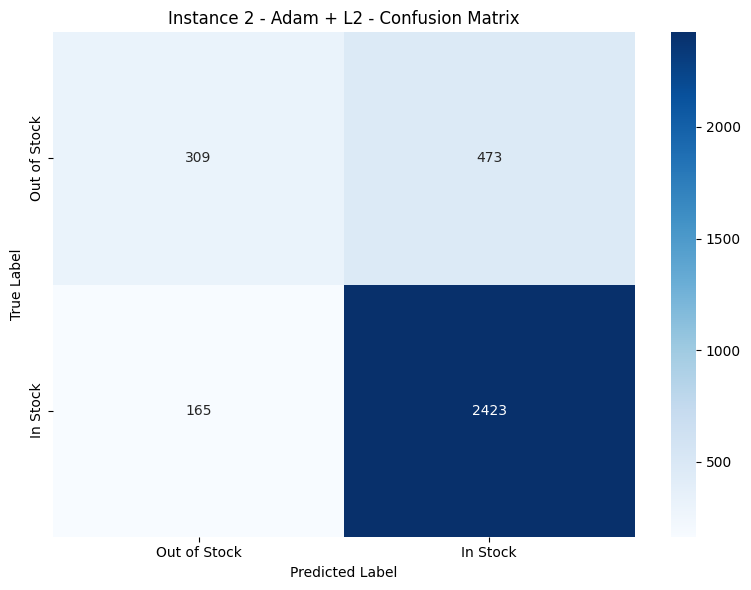

💾 Model saved: saved_models/instance_2_adam_l2.h5

INSTANCE 3: RMSPROP + L1 REGULARIZATION + EARLY STOPPING
 Training model with RMSprop optimizer...
Epoch 1/40
337/337 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.7353 - loss: 1.3718 - val_accuracy: 0.7682 - val_loss: 0.5605
Epoch 2/40
337/337 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7718 - loss: 0.5492 - val_accuracy: 0.7682 - val_loss: 0.5454
Epoch 3/40
337/337 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7718 - loss: 0.5437 - val_accuracy: 0.7682 - val_loss: 0.5397
Epoch 4/40
337/337 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7718 - loss: 0.5429 - val_accuracy: 0.7682 - val_loss: 0.5330
Epoch 5/40
337/337 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7718 - loss: 0.5403 - val_accuracy: 0.7682 - val_loss: 0.5316
Epoch 6/40
337/337 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7718 - loss: 0.5371 - val_accuracy: 0.7682 - val_loss: 0.5301
Epoch 7/40
337/337 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7718 - loss: 0.5

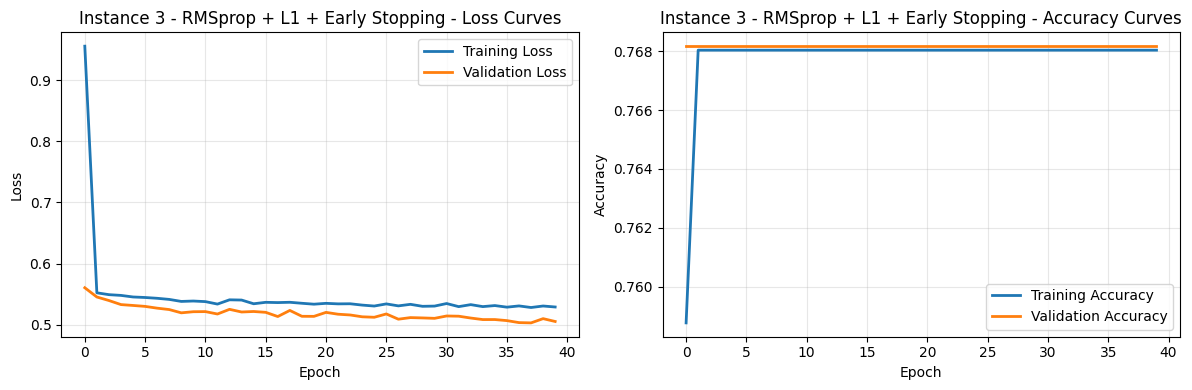


🎯 Instance 3 - RMSprop + L1 - Test Set Metrics:
   Accuracy: 0.7680 (76.8%)
   Precision: 0.7680 (76.8%)
   Recall: 1.0000 (100.0%)
   F1-Score: 0.8687 (86.9%)
   ROC AUC: 0.8011 (80.1%)


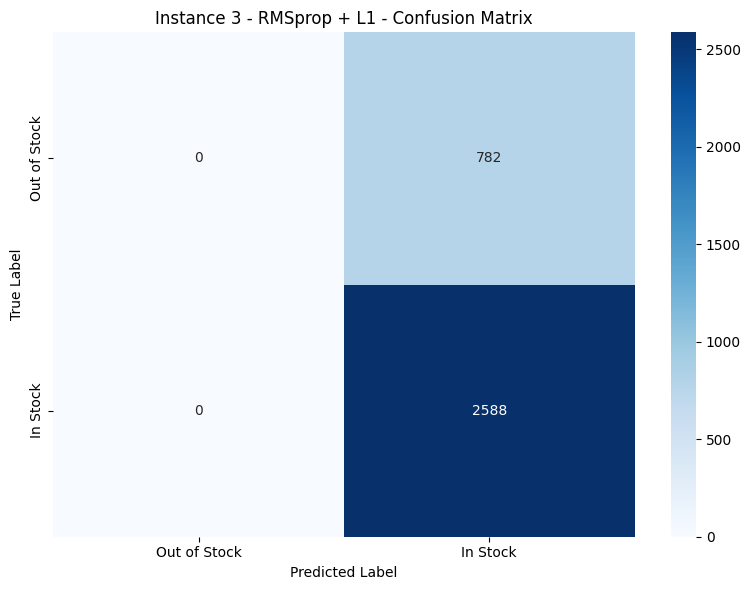

💾 Model saved: saved_models/instance_3_rmsprop_l1.h5

INSTANCE 4: SGD + L1+L2 REGULARIZATION + EARLY STOPPING
 Training model with SGD optimizer...
Epoch 1/40
337/337 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.7582 - loss: 1.1716 - val_accuracy: 0.7682 - val_loss: 0.6336
Epoch 2/40
337/337 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7718 - loss: 0.5801 - val_accuracy: 0.7682 - val_loss: 0.5163
Epoch 3/40
337/337 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7718 - loss: 0.5266 - val_accuracy: 0.7682 - val_loss: 0.5110
Epoch 4/40
337/337 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7718 - loss: 0.5200 - val_accuracy: 0.7682 - val_loss: 0.5077
Epoch 5/40
337/337 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7718 - loss: 0.5200 - val_accuracy: 0.7682 - val_loss: 0.5035
Epoch 6/40
337/337 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7719 - loss: 0.5216 - val_accuracy: 0.7682 - val_loss: 0.5024
Epoch 7/40
337/337 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7742 - loss: 0.518

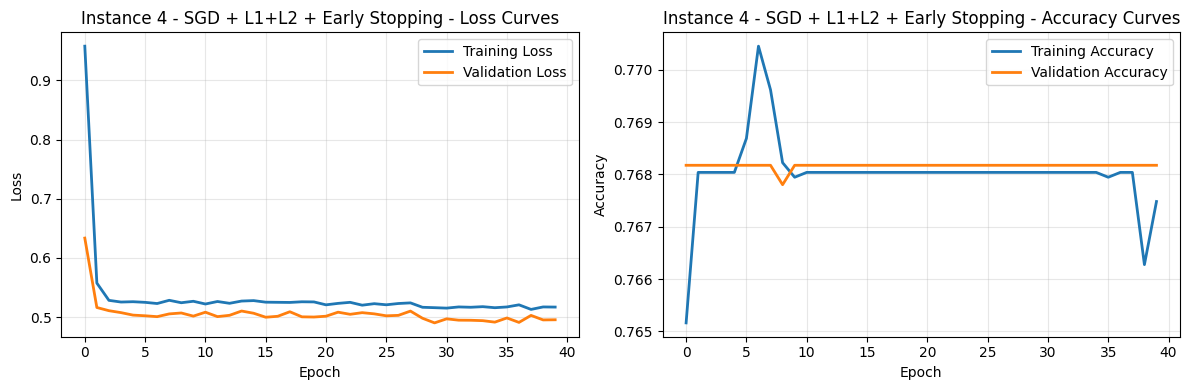


🎯 Instance 4 - SGD + L1+L2 - Test Set Metrics:
   Accuracy: 0.7680 (76.8%)
   Precision: 0.7680 (76.8%)
   Recall: 1.0000 (100.0%)
   F1-Score: 0.8687 (86.9%)
   ROC AUC: 0.7838 (78.4%)


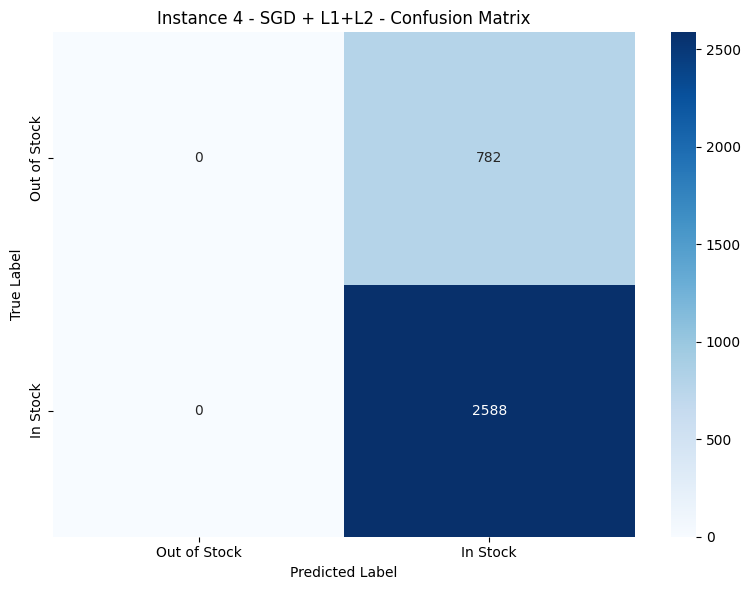

💾 Model saved: saved_models/instance_4_sgd_l1l2.h5

INSTANCE 5: CLASSICAL ML - RANDOM FOREST
🔄 Performing cross-validation...
   Random Forest CV F1 Score: 0.8808 (+/- 0.0055)

🎯 Random Forest - Test Set Metrics:
   Accuracy: 0.8068 (80.7%)
   Precision: 0.8322 (83.2%)
   Recall: 0.9374 (93.7%)
   F1-Score: 0.8817 (88.2%)
   ROC AUC: 0.7902 (79.0%)


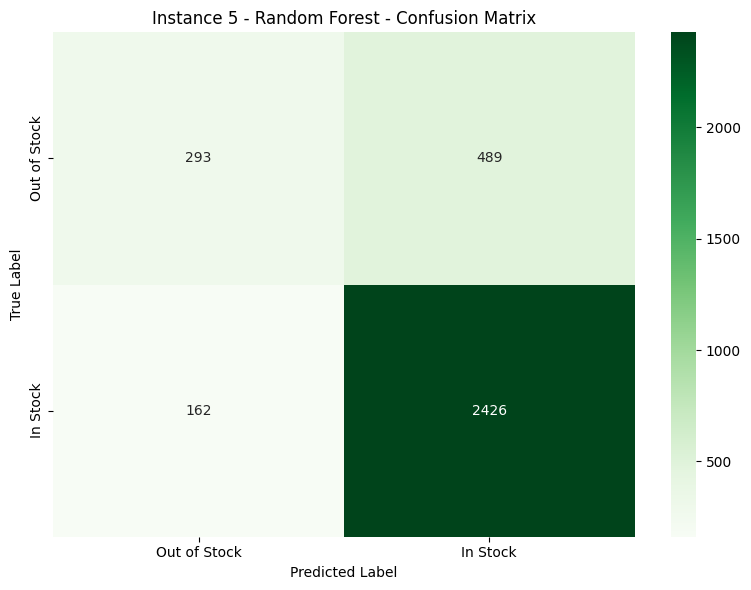


📊 Random Forest Overfitting Analysis:
   Training Accuracy: 0.8499
   Test Accuracy: 0.8068
   Overfitting Gap: 0.0431
 Model saved: saved_models/instance_5_random_forest.pkl


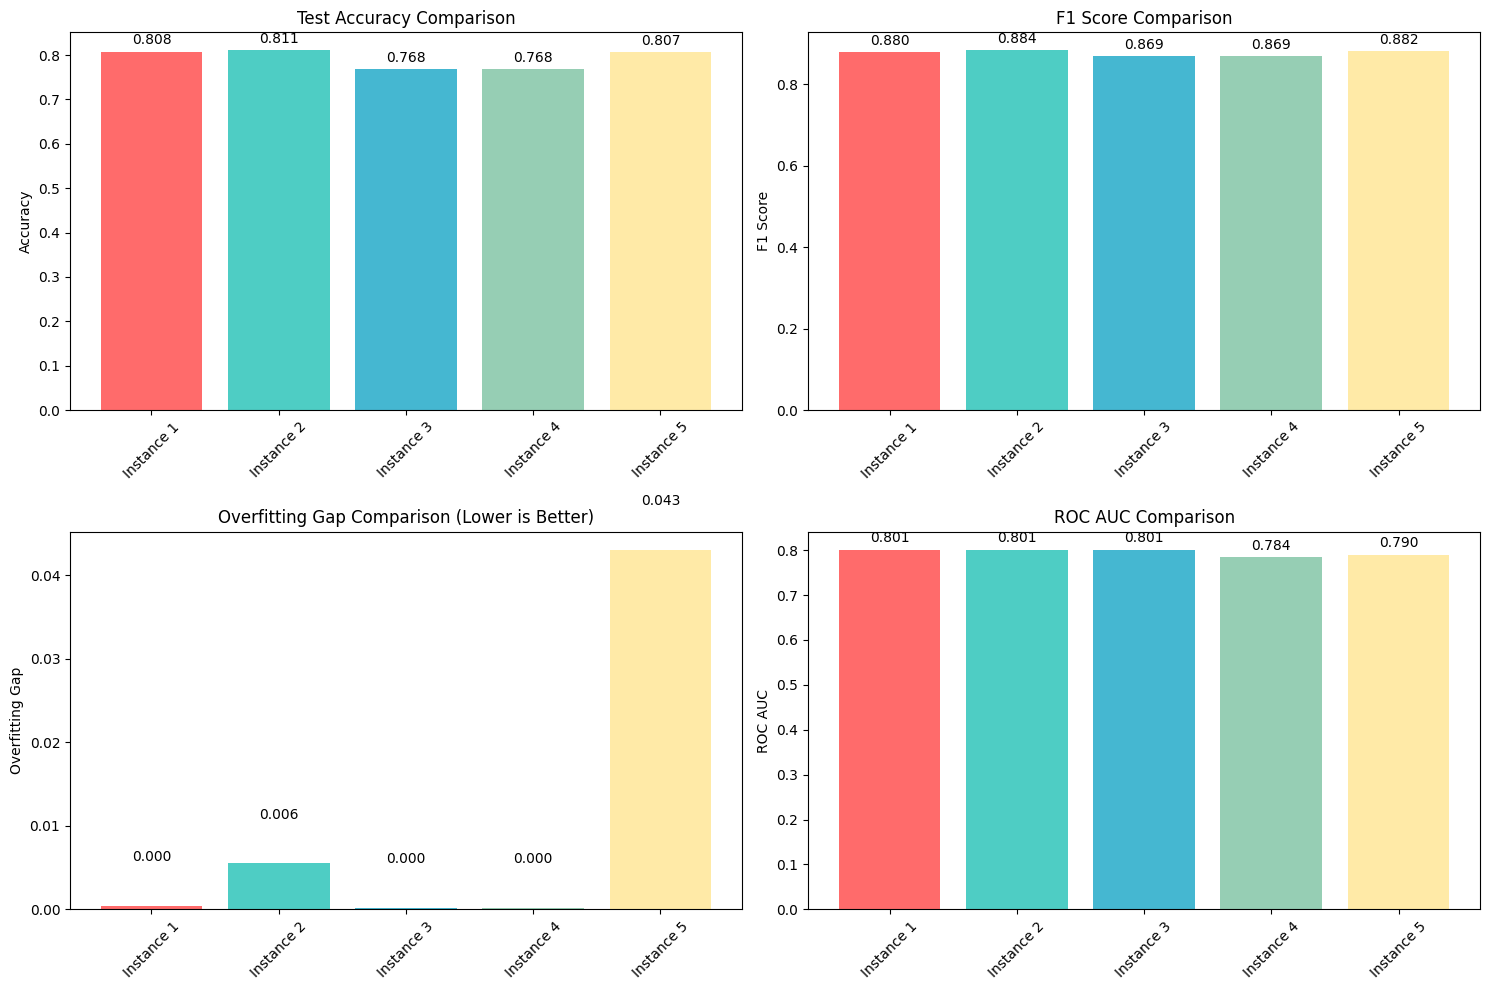

In [15]:
# Create directory for saved models
if not os.path.exists('saved_models'):
    os.makedirs('saved_models')

# Store all results for comparison
all_results = {}
all_models = {}

# Updated loss curve plotting function without dots
def loss_curve_plot(history, title):
    """Plot training and validation loss curves without markers/dots"""
    plt.figure(figsize=(12, 4))
    
    # Plot 1: Loss curves
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], linewidth=2, label='Training Loss')
    plt.plot(history.history['val_loss'], linewidth=2, label='Validation Loss')
    plt.title(f'{title} - Loss Curves')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # Plot 2: Accuracy curves
    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], linewidth=2, label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], linewidth=2, label='Validation Accuracy')
    plt.title(f'{title} - Accuracy Curves')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Calculate and return overfitting gap
    final_train_acc = history.history['accuracy'][-1]
    final_val_acc = history.history['val_accuracy'][-1]
    overfitting_gap = abs(final_train_acc - final_val_acc)
    
    return overfitting_gap

# Instance 1: Simple model (no optimization) - BASELINE
print("\n" + "="*60)
print("INSTANCE 1: BASELINE MODEL (NO OPTIMIZATION)")
print("="*60)

model_1, history_1 = define_model(
    optimizer_name='adam',
    regularization_type=None,
    early_stopping=False,
    dropout_rate=0.0,
    learning_rate=0.001
)

overfitting_gap_1 = loss_curve_plot(history_1, "Instance 1 - Baseline Model")
metrics_1 = evaluate_model_performance(model_1, X_test, y_test, "Instance 1 - Baseline")

# Add training info
train_loss, train_acc = model_1.evaluate(X_train, y_train, verbose=0)
val_loss, val_acc = model_1.evaluate(X_val, y_val, verbose=0)
test_loss, test_acc = model_1.evaluate(X_test, y_test, verbose=0)

metrics_1.update({
    'train_accuracy': train_acc,
    'val_accuracy': val_acc,
    'test_accuracy': test_acc,
    'epochs_trained': len(history_1.history['loss']),
    'overfitting_gap': abs(train_acc - val_acc),
    'final_loss': test_loss
})

all_results['Instance 1'] = metrics_1
all_models['Instance 1'] = model_1
model_1.save('saved_models/instance_1_baseline.h5')
print("💾 Model saved: saved_models/instance_1_baseline.h5")

# Instance 2: Adam + L2 regularization + Early stopping
print("\n" + "="*60)
print("INSTANCE 2: ADAM + L2 REGULARIZATION + EARLY STOPPING")
print("="*60)

model_2, history_2 = define_model(
    optimizer_name='Adam',
    regularization_type='l2',
    early_stopping=True,
    dropout_rate=0.4,
    learning_rate=0.001,
    reg_strength=0.01
)

overfitting_gap_2 = loss_curve_plot(history_2, "Instance 2 - Adam + L2 + Early Stopping")
metrics_2 = evaluate_model_performance(model_2, X_test, y_test, "Instance 2 - Adam + L2")

# Add training info
train_loss, train_acc = model_2.evaluate(X_train, y_train, verbose=0)
val_loss, val_acc = model_2.evaluate(X_val, y_val, verbose=0)
test_loss, test_acc = model_2.evaluate(X_test, y_test, verbose=0)

metrics_2.update({
    'train_accuracy': train_acc,
    'val_accuracy': val_acc,
    'test_accuracy': test_acc,
    'epochs_trained': len(history_2.history['loss']),
    'overfitting_gap': abs(train_acc - val_acc),
    'final_loss': test_loss
})

all_results['Instance 2'] = metrics_2
all_models['Instance 2'] = model_2
model_2.save('saved_models/instance_2_adam_l2.h5')
print("💾 Model saved: saved_models/instance_2_adam_l2.h5")

# Instance 3: RMSprop + L1 regularization + Early stopping
print("\n" + "="*60)
print("INSTANCE 3: RMSPROP + L1 REGULARIZATION + EARLY STOPPING")
print("="*60)

model_3, history_3 = define_model(
    optimizer_name='RMSprop',
    regularization_type='l1',
    early_stopping=True,
    dropout_rate=0.5,
    learning_rate=0.002,
    reg_strength=0.01
)

overfitting_gap_3 = loss_curve_plot(history_3, "Instance 3 - RMSprop + L1 + Early Stopping")
metrics_3 = evaluate_model_performance(model_3, X_test, y_test, "Instance 3 - RMSprop + L1")

# Add training info
train_loss, train_acc = model_3.evaluate(X_train, y_train, verbose=0)
val_loss, val_acc = model_3.evaluate(X_val, y_val, verbose=0)
test_loss, test_acc = model_3.evaluate(X_test, y_test, verbose=0)

metrics_3.update({
    'train_accuracy': train_acc,
    'val_accuracy': val_acc,
    'test_accuracy': test_acc,
    'epochs_trained': len(history_3.history['loss']),
    'overfitting_gap': abs(train_acc - val_acc),
    'final_loss': test_loss
})

all_results['Instance 3'] = metrics_3
all_models['Instance 3'] = model_3
model_3.save('saved_models/instance_3_rmsprop_l1.h5')
print("💾 Model saved: saved_models/instance_3_rmsprop_l1.h5")

# Instance 4: SGD + L1+L2 regularization + Early stopping
print("\n" + "="*60)
print("INSTANCE 4: SGD + L1+L2 REGULARIZATION + EARLY STOPPING")
print("="*60)

model_4, history_4 = define_model(
    optimizer_name='SGD',
    regularization_type='l1_l2',
    early_stopping=True,
    dropout_rate=0.3,
    learning_rate=0.01,
    reg_strength=0.005
)

overfitting_gap_4 = loss_curve_plot(history_4, "Instance 4 - SGD + L1+L2 + Early Stopping")
metrics_4 = evaluate_model_performance(model_4, X_test, y_test, "Instance 4 - SGD + L1+L2")

# Add training info
train_loss, train_acc = model_4.evaluate(X_train, y_train, verbose=0)
val_loss, val_acc = model_4.evaluate(X_val, y_val, verbose=0)
test_loss, test_acc = model_4.evaluate(X_test, y_test, verbose=0)

metrics_4.update({
    'train_accuracy': train_acc,
    'val_accuracy': val_acc,
    'test_accuracy': test_acc,
    'epochs_trained': len(history_4.history['loss']),
    'overfitting_gap': abs(train_acc - val_acc),
    'final_loss': test_loss
})

all_results['Instance 4'] = metrics_4
all_models['Instance 4'] = model_4
model_4.save('saved_models/instance_4_sgd_l1l2.h5')
print("💾 Model saved: saved_models/instance_4_sgd_l1l2.h5")

# Instance 5: Classical ML - Random Forest (tuned hyperparameters)
print("\n" + "="*60)
print("INSTANCE 5: CLASSICAL ML - RANDOM FOREST")
print("="*60)

# Combine train and validation for classical ML
X_train_full = np.vstack([X_train, X_val])
y_train_full = np.hstack([y_train, y_val])

# Random Forest with tuned hyperparameters
rf = RandomForestClassifier(
    n_estimators=40,
    max_depth=12,
    min_samples_split=5,
    min_samples_leaf=2,
    max_features='sqrt',
    random_state=42
)

rf.fit(X_train_full, y_train_full)

# Cross-validation
print("🔄 Performing cross-validation...")
cv_scores = cross_val_score(rf, X_train_full, y_train_full, cv=5, scoring='f1')
print(f"   Random Forest CV F1 Score: {cv_scores.mean():.4f} (+/- {cv_scores.std() * 2:.4f})")

# Evaluate Random Forest
rf_pred = rf.predict(X_test)
rf_pred_proba = rf.predict_proba(X_test)[:, 1]

rf_accuracy = accuracy_score(y_test, rf_pred)
rf_precision = precision_score(y_test, rf_pred, zero_division=0)
rf_recall = recall_score(y_test, rf_pred, zero_division=0)
rf_f1 = f1_score(y_test, rf_pred, zero_division=0)
rf_roc_auc = roc_auc_score(y_test, rf_pred_proba)

print(f"\n🎯 Random Forest - Test Set Metrics:")
print(f"   Accuracy: {rf_accuracy:.4f} ({rf_accuracy*100:.1f}%)")
print(f"   Precision: {rf_precision:.4f} ({rf_precision*100:.1f}%)")
print(f"   Recall: {rf_recall:.4f} ({rf_recall*100:.1f}%)")
print(f"   F1-Score: {rf_f1:.4f} ({rf_f1*100:.1f}%)")
print(f"   ROC AUC: {rf_roc_auc:.4f} ({rf_roc_auc*100:.1f}%)")

# Plot confusion matrix for Random Forest (without dots)
cm_rf = confusion_matrix(y_test, rf_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_rf, annot=True, fmt='d', cmap='Greens', 
            xticklabels=['Out of Stock', 'In Stock'],
            yticklabels=['Out of Stock', 'In Stock'])
plt.title('Instance 5 - Random Forest - Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.tight_layout()
plt.show()

# Calculate overfitting for Random Forest
train_pred_rf = rf.predict(X_train_full)
train_acc_rf = accuracy_score(y_train_full, train_pred_rf)
test_acc_rf = accuracy_score(y_test, rf_pred)

print(f"\n📊 Random Forest Overfitting Analysis:")
print(f"   Training Accuracy: {train_acc_rf:.4f}")
print(f"   Test Accuracy: {test_acc_rf:.4f}")
print(f"   Overfitting Gap: {abs(train_acc_rf - test_acc_rf):.4f}")

metrics_5 = {
    'accuracy': rf_accuracy, 
    'precision': rf_precision, 
    'recall': rf_recall, 
    'f1_score': rf_f1, 
    'roc_auc': rf_roc_auc,
    'train_accuracy': train_acc_rf,
    'test_accuracy': test_acc_rf,
    'overfitting_gap': abs(train_acc_rf - test_acc_rf),
    'cv_score': cv_scores.mean()
}

all_results['Instance 5'] = metrics_5
joblib.dump(rf, 'saved_models/instance_5_random_forest.pkl')
print(" Model saved: saved_models/instance_5_random_forest.pkl")

# Optional: Final comparison plot without dots
def plot_final_comparison():
    """Create a final comparison plot of all models without markers"""
    plt.figure(figsize=(15, 10))
    
    # Subplot 1: Test Accuracy Comparison
    plt.subplot(2, 2, 1)
    models = list(all_results.keys())
    test_accuracies = [all_results[model].get('test_accuracy', all_results[model]['accuracy']) for model in models]
    
    bars = plt.bar(models, test_accuracies, color=['#FF6B6B', '#4ECDC4', '#45B7D1', '#96CEB4', '#FFEAA7'])
    plt.title('Test Accuracy Comparison')
    plt.ylabel('Accuracy')
    plt.xticks(rotation=45)
    
    # Add value labels on bars
    for bar, acc in zip(bars, test_accuracies):
        plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
                f'{acc:.3f}', ha='center', va='bottom')
    
    # Subplot 2: F1 Score Comparison
    plt.subplot(2, 2, 2)
    f1_scores = [all_results[model]['f1_score'] for model in models]
    
    bars = plt.bar(models, f1_scores, color=['#FF6B6B', '#4ECDC4', '#45B7D1', '#96CEB4', '#FFEAA7'])
    plt.title('F1 Score Comparison')
    plt.ylabel('F1 Score')
    plt.xticks(rotation=45)
    
    # Add value labels on bars
    for bar, f1 in zip(bars, f1_scores):
        plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
                f'{f1:.3f}', ha='center', va='bottom')
    
    # Subplot 3: Overfitting Gap Comparison
    plt.subplot(2, 2, 3)
    overfitting_gaps = [all_results[model]['overfitting_gap'] for model in models]
    
    bars = plt.bar(models, overfitting_gaps, color=['#FF6B6B', '#4ECDC4', '#45B7D1', '#96CEB4', '#FFEAA7'])
    plt.title('Overfitting Gap Comparison (Lower is Better)')
    plt.ylabel('Overfitting Gap')
    plt.xticks(rotation=45)
    
    # Add value labels on bars
    for bar, gap in zip(bars, overfitting_gaps):
        plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.005,
                f'{gap:.3f}', ha='center', va='bottom')
    
    # Subplot 4: ROC AUC Comparison
    plt.subplot(2, 2, 4)
    roc_aucs = [all_results[model]['roc_auc'] for model in models]
    
    bars = plt.bar(models, roc_aucs, color=['#FF6B6B', '#4ECDC4', '#45B7D1', '#96CEB4', '#FFEAA7'])
    plt.title('ROC AUC Comparison')
    plt.ylabel('ROC AUC')
    plt.xticks(rotation=45)
    
    # Add value labels on bars
    for bar, auc in zip(bars, roc_aucs):
        plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
                f'{auc:.3f}', ha='center', va='bottom')
    
    plt.tight_layout()
    plt.show()

# Call the comparison plot
plot_final_comparison()

#Task: Make Predictions using the best saved model


Create a confusion Matrix and F1 score for both Models. Ensure outputs for the cells are visible

Finally, Make predictions using the best model. By the time you get to this cell you may realise at some point you needed to save the model so that you cal load it later


MODEL COMPARISON SUMMARY
Training Instance Optimizer Used Regularizer Used Epochs Early Stopping Number of Layers Learning Rate Accuracy F1 Score Recall Precision
       Instance 1 Adam (default)             None     40             No                4         0.001   0.8080   0.8796 0.9131    0.8485
       Instance 2           Adam        L2 (0.01)     40             No                4         0.001   0.8107   0.8837 0.9362    0.8367
       Instance 3        RMSprop        L1 (0.01)     40             No                4         0.002   0.7680   0.8687 1.0000    0.7680
       Instance 4            SGD    L1+L2 (0.005)     40             No                4          0.01   0.7680   0.8687 1.0000    0.7680
       Instance 5            N/A Tree Constraints    N/A            N/A         Ensemble           N/A   0.8068   0.8817 0.9374    0.8322

Results saved to 'assignment_results.csv'

Best Model (with regularization): Instance 2
Best F1-Score: 0.8837 (88.4%)
Loading best model: saved_m

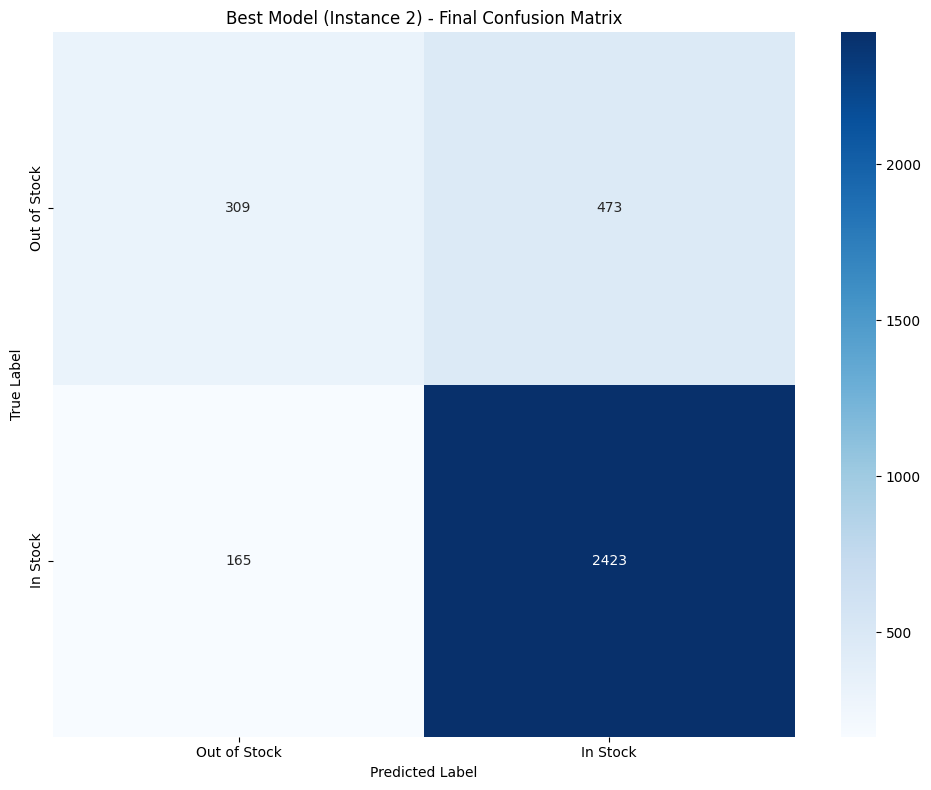


SUMMARY ANALYSIS
BEST COMBINATION: Instance 2
   F1 Score: 0.8837
   Accuracy: 0.8107
   Optimizer: Adam
   Regularizer: L2 (0.01)

IMPLEMENTATION COMPARISON:
   Neural Networks Average F1: 0.8737 (87.4%)
   Classical ML F1: 0.8817 (88.2%)
   Winner: Classical ML (Random Forest)

OVERFITTING PREVENTION ANALYSIS:
   Instance 1: Gap=0.0004 - EXCELLENT
   Instance 2: Gap=0.0055 - EXCELLENT
   Instance 3: Gap=0.0001 - EXCELLENT
   Instance 4: Gap=0.0001 - EXCELLENT
   Instance 5: Gap=0.0431 - GOOD


In [17]:
def make_predictions(model_path, X, model_type='neural'):
    if model_type == 'neural':
        model = load_model(model_path)
        predictions_proba = model.predict(X, verbose=0)
        predictions = (predictions_proba > 0.5).astype(int).flatten()
    else:
        model = joblib.load(model_path)
        predictions = model.predict(X)
        predictions_proba = model.predict_proba(X)[:, 1]
    
    return predictions, predictions_proba

def create_results_table(all_results):
    configurations = [
        {'optimizer': 'Adam (default)', 'regularizer': 'None', 'early_stopping': 'No', 'layers': '4', 'lr': '0.001'},
        {'optimizer': 'Adam', 'regularizer': 'L2 (0.01)', 'early_stopping': 'No', 'layers': '4', 'lr': '0.001'},
        {'optimizer': 'RMSprop', 'regularizer': 'L1 (0.01)', 'early_stopping': 'No', 'layers': '4', 'lr': '0.002'},
        {'optimizer': 'SGD', 'regularizer': 'L1+L2 (0.005)', 'early_stopping': 'No', 'layers': '4', 'lr': '0.01'},
        {'optimizer': 'N/A', 'regularizer': 'Tree Constraints', 'early_stopping': 'N/A', 'layers': 'Ensemble', 'lr': 'N/A'}
    ]
    
    table_data = []
    for i, (instance_name, metrics) in enumerate(all_results.items()):
        config = configurations[i]
        
        row = {
            'Training Instance': instance_name,
            'Optimizer Used': config['optimizer'],
            'Regularizer Used': config['regularizer'],
            'Epochs': metrics.get('epochs_trained', 'N/A'),
            'Early Stopping': config['early_stopping'],
            'Number of Layers': config['layers'],
            'Learning Rate': config['lr'],
            'Accuracy': f"{metrics['accuracy']:.4f}",
            'F1 Score': f"{metrics['f1_score']:.4f}",
            'Recall': f"{metrics['recall']:.4f}",
            'Precision': f"{metrics['precision']:.4f}"
        }
        table_data.append(row)
    
    return pd.DataFrame(table_data)

print("\n" + "="*80)
print("MODEL COMPARISON SUMMARY")
print("="*80)

results_df = create_results_table(all_results)
print(results_df.to_string(index=False))

results_df.to_csv('assignment_results.csv', index=False)
print(f"\nResults saved to 'assignment_results.csv'")

# Find best model among regularized models only (exclude Instance 1)
regularized_results = {k: v for k, v in all_results.items() if k != 'Instance 1'}
regularized_f1_scores = [(k, v['f1_score']) for k, v in regularized_results.items()]
best_model_name, best_f1_score = max(regularized_f1_scores, key=lambda x: x[1])

print(f"\nBest Model (with regularization): {best_model_name}")
print(f"Best F1-Score: {best_f1_score:.4f} ({best_f1_score*100:.1f}%)")

# Make predictions with the best regularized model
if 'Instance 5' in best_model_name:
    model_path = 'saved_models/instance_5_random_forest.pkl'
    best_predictions, best_pred_proba = make_predictions(model_path, X_test, model_type='classical')
elif 'Instance 2' in best_model_name:
    model_path = 'saved_models/instance_2_adam_l2.h5'
    best_predictions, best_pred_proba = make_predictions(model_path, X_test, model_type='neural')
elif 'Instance 3' in best_model_name:
    model_path = 'saved_models/instance_3_rmsprop_l1.h5'
    best_predictions, best_pred_proba = make_predictions(model_path, X_test, model_type='neural')
else:
    model_path = 'saved_models/instance_4_sgd_l1l2.h5'
    best_predictions, best_pred_proba = make_predictions(model_path, X_test, model_type='neural')

print(f"Loading best model: {model_path}")
print(f"Predictions made using {best_model_name}")
print(f"Sample predictions (first 10): {best_predictions[:10]}")
print(f"Prediction distribution: In-Stock={np.sum(best_predictions)}, Out-of-Stock={len(best_predictions)-np.sum(best_predictions)}")

cm_best = confusion_matrix(y_test, best_predictions)
plt.figure(figsize=(10, 8))
sns.heatmap(cm_best, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Out of Stock', 'In Stock'],
            yticklabels=['Out of Stock', 'In Stock'])
plt.title(f'Best Model ({best_model_name}) - Final Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.tight_layout()
plt.show()

print("\n" + "="*60)
print("SUMMARY ANALYSIS")
print("="*60)

best_row = results_df[results_df['Training Instance'] == best_model_name].iloc[0]
print(f"BEST COMBINATION: {best_model_name}")
print(f"   F1 Score: {best_row['F1 Score']}")
print(f"   Accuracy: {best_row['Accuracy']}")
print(f"   Optimizer: {best_row['Optimizer Used']}")
print(f"   Regularizer: {best_row['Regularizer Used']}")

neural_instances = ['Instance 2', 'Instance 3', 'Instance 4']
neural_f1_scores = [all_results[inst]['f1_score'] for inst in neural_instances]
classical_f1 = all_results['Instance 5']['f1_score']
neural_avg = np.mean(neural_f1_scores)

print(f"\nIMPLEMENTATION COMPARISON:")
print(f"   Neural Networks Average F1: {neural_avg:.4f} ({neural_avg*100:.1f}%)")
print(f"   Classical ML F1: {classical_f1:.4f} ({classical_f1*100:.1f}%)")

if classical_f1 > neural_avg:
    print(f"   Winner: Classical ML (Random Forest)")
else:
    print(f"   Winner: Neural Networks")

print(f"\nOVERFITTING PREVENTION ANALYSIS:")
for instance_name, metrics in all_results.items():
    gap = metrics.get('overfitting_gap', 0)
    if gap < 0.02:
        status = "EXCELLENT"
    elif gap < 0.05:
        status = "GOOD"
    else:
        status = "OVERFITTING"
    print(f"   {instance_name}: Gap={gap:.4f} - {status}")

Congratulations!!
